In [1]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge, Dropout
from keras.models import Model
from keras import backend as K    
K.set_image_dim_ordering('th') 

/home/manoj/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
corpus = pd.read_pickle('../data/MR.pkl')
corpus= corpus.sample(frac=1)
sentences, labels = list(corpus.sentence), list(corpus.label)
print len(sentences)

10662


In [3]:
corpus.head(5)

,label,sentence,split
6745,1,"just as moving , uplifting and funny as ever .",train
9703,1,"full of detail about the man and his country ,...",train
7891,1,"it may not be history but then again , what if...",train
606,0,"a markedly inactive film , city is conversatio...",train
7571,1,"a smart , sassy and exceptionally charming rom...",train


In [4]:
#Increasing the value will increase sequence length in many sentences. Captures more words
TOP_N_WORDS = 5000

In [5]:
tokenizer = Tokenizer(nb_words=TOP_N_WORDS)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

/home/manoj/anaconda2/lib/python2.7/site-packages/keras/preprocessing/text.py:157: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 18758 unique tokens.


In [6]:
#This will show how the first sentence has been converted to numeric sequence
print sequences[0]
#This will show the first sentence itself
print "Sentence: "+sentences[0]
#This will loop through every word of the first sentence and see which word is not added in the sequence.
print "Comment: Words not added from the first sentence along with their ID`s"
words = sentences[0].split(" ")
for i in words:
    if i in word_index:
        if word_index[i] not in sequences[0]:
            print i, word_index[i]

[48, 11, 269, 2000, 3, 70, 11, 148]
Sentence: just as moving , uplifting and funny as ever .
Comment: Words not added from the first sentence along with their ID`s


In [7]:
max_sequence_length = 0
min_sequence_length = -1
j = -1
for i in sequences:
    seq_len = len(i)
    
    if min_sequence_length == -1:
        min_sequence_length = seq_len
        
    if seq_len > max_sequence_length:
        max_sequence_length = seq_len
    
    if seq_len < min_sequence_length and min_sequence_length!=-1:
        min_sequence_length = seq_len
        j = i
        
print min_sequence_length
print max_sequence_length

0
51


In [8]:
data = pad_sequences(sequences, maxlen=max_sequence_length)
import numpy as np
data_labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', data_labels.shape)

('Shape of data tensor:', (10662, 51))
('Shape of label tensor:', (10662, 2))


In [9]:
data[0]
data_labels[0]

array([0., 1.])

In [32]:
import os
GLOVE_DIR = "/home/manoj/Downloads/glove.6B/"
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print "Loaded "+str(len(embeddings_index))+" word embeddings from GLOVE"

Loaded 400000 word embeddings from GLOVE


In [33]:
EMBEDDING_DIM = len(embeddings_index["the"])

In [34]:
import pickle
lexical_prob = pickle.load(open("../data/lexical_prob.pkl","rb"))

In [35]:
#+1 for bias.
#len(word_index) because we have so many unique tokens after all the filtering.

embedding_matrix = np.random.random((len(word_index)+ 1, EMBEDDING_DIM + len(lexical_prob["the"]) ))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be random numbers.
        embedding_matrix[i] = np.append(embedding_vector, lexical_prob[word])
    #embedding_matrix[i] = np.append(embedding_matrix[i], lexical_prob[word])

In [36]:
embedding_matrix.shape

(18759, 145)

In [37]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM + len(lexical_prob["the"]),
                            weights=[embedding_matrix],
                            input_length=max_sequence_length,
                            trainable=True)

In [38]:
sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
#x = Conv1D(128, 5, activation='relu')(x)
#x = MaxPooling1D(5)(x)
x = Flatten()(x)
#x = Dense(128, activation='relu')(x)
x = Dense(100, activation='relu')(x)
preds = Dense(2, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 51)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 51, 145)           2720055   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 47, 128)           92928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 9, 128)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               115300    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total para

In [40]:
performance = model.fit(data, data_labels,epochs=10, batch_size=128, validation_split=0.1)

Train on 9595 samples, validate on 1067 samples
Epoch 1/10
9595/9595 [==============================] - 9s 979us/step - loss: 0.7171 - acc: 0.5427 - val_loss: 0.6621 - val_acc: 0.6523
Epoch 2/10
9595/9595 [==============================] - 9s 953us/step - loss: 0.6006 - acc: 0.6797 - val_loss: 0.5447 - val_acc: 0.6982
Epoch 3/10
9595/9595 [==============================] - 9s 954us/step - loss: 0.4440 - acc: 0.7967 - val_loss: 0.5500 - val_acc: 0.7226
Epoch 4/10
9595/9595 [==============================] - 9s 949us/step - loss: 0.3293 - acc: 0.8578 - val_loss: 0.5371 - val_acc: 0.7320
Epoch 5/10
9595/9595 [==============================] - 9s 967us/step - loss: 0.2102 - acc: 0.9182 - val_loss: 0.6096 - val_acc: 0.7338
Epoch 6/10
9595/9595 [==============================] - 10s 996us/step - loss: 0.1198 - acc: 0.9578 - val_loss: 0.7613 - val_acc: 0.7235
Epoch 7/10
9595/9595 [==============================] - 9s 980us/step - loss: 0.0692 - acc: 0.9761 - val_loss: 0.8476 - val_acc: 0.7432

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

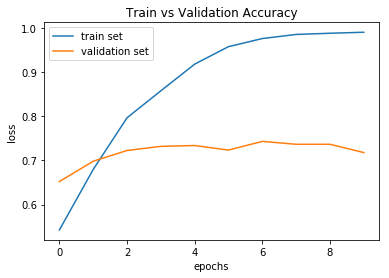

In [42]:
plt.plot(performance.history['acc'])
plt.plot(performance.history['val_acc'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train set', 'validation set'], loc='best')
plt.title('Train vs Validation Accuracy')